# Assignment 1: Logistic Regression
Welcome to week one of this specialization. You will learn about logistic regression. Concretely, you will be implementing logistic regression for sentiment analysis on tweets. Given a tweet, you will decide if it has a positive sentiment or a negative one. Specifically you will: 

* Learn how to extract features for logistic regression given some text
* Implement logistic regression from scratch
* Apply logistic regression on a natural language processing task
* Test using your logistic regression
* Perform error analysis

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader Error: Grader feedback not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/classification-vector-spaces-in-nlp/supplement/YLuAg/h-ow-to-refresh-your-workspace).

Lets get started!

We will be using a data set of tweets. Hopefully you will get more than 99% accuracy.  
Run the cell below to load in the packages.

## Table of Contents

- [Import Functions and Data](#0)
- [1 - Logistic Regression](#1)
    - [1.1 - Sigmoid](#1-1)
        - [Exercise 1 - sigmoid (UNQ_C1)](#ex-1)
    - [1.2 - Cost function and Gradient](#1-2)
        - [Exercise 2 - gradientDescent (UNQ_C2)](#ex-2)
- [2 - Extracting the Features](#2)
    - [Exercise 3 - extract_features (UNQ_C3)](#ex-3)
- [3 - Training Your Model](#3)
- [4 - Test your Logistic Regression](#4)
    - [Exercise 4 - predict_tweet (UNQ_C4)](#ex-4)
    - [4.1 - Check the Performance using the Test Set](#4-1)
        - [Exercise 5 - test_logistic_regression (UNQ_C5)](#ex-5)
- [5 - Error Analysis](#5)
- [6 - Predict with your own Tweet](#6)

<a name='0'></a>
## Import Functions and Data

In [46]:
# run this cell to import nltk
import nltk
from os import getcwd
import w1_unittest

nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Imported Functions

Download the data needed for this assignment. Check out the [documentation for the twitter_samples dataset](http://www.nltk.org/howto/twitter.html).

* twitter_samples: if you're running this notebook on your local computer, you will need to download it using:
```Python
nltk.download('twitter_samples')
```

* stopwords: if you're running this notebook on your local computer, you will need to download it using:
```python
nltk.download('stopwords')
```

#### Import some helper functions that we provided in the utils.py file:
* process_tweet: cleans the text, tokenizes it into separate words, removes stopwords, and converts words to stems.
* build_freqs: this counts how often a word in the 'corpus' (the entire set of tweets) was associated with a positive label '1' or a negative label '0', then builds the 'freqs' dictionary, where each key is the (word,label) tuple, and the value is the count of its frequency within the corpus of tweets.

In [47]:
filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)

In [48]:
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples 

from utils import process_tweet, build_freqs

### Prepare the Data
* The `twitter_samples` contains subsets of five thousand positive_tweets, five thousand negative_tweets, and the full set of 10,000 tweets.  
    * If you used all three datasets, we would introduce duplicates of the positive tweets and negative tweets.  
    * You will select just the five thousand positive tweets and five thousand negative tweets.

In [49]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

* Train test split: 20% will be in the test set, and 80% in the training set.


In [50]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

* Create the numpy array of positive labels and negative labels.

In [51]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [52]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


* Create the frequency dictionary using the imported build_freqs function.  
    * We highly recommend that you open utils.py and read the build_freqs function to understand what it is doing.
    * To view the file directory, go to the menu and click File->Open.

```Python
    for y,tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
```
* Notice how the outer for loop goes through each tweet, and the inner for loop steps through each word in a tweet.
* The 'freqs' dictionary is the frequency dictionary that's being built. 
* The key is the tuple (word, label), such as ("happy",1) or ("happy",0).  The value stored for each key is the count of how many times the word "happy" was associated with a positive label, or how many times "happy" was associated with a negative label.

In [53]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11436


#### Expected output
```
type(freqs) = <class 'dict'>
len(freqs) = 11436
```

### Process Tweet
The given function 'process_tweet' tokenizes the tweet into individual words, removes stop words and applies stemming.

In [54]:
# test the function below
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


#### Expected output
```
This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
 
This is an example of the processes version: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']
```

<a name='1'></a>
## 1 - Logistic Regression 

<a name='1-1'></a>
### 1.1 - Sigmoid
You will learn to use logistic regression for text classification. 
* The sigmoid function is defined as: 

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability. 

<div style="width:image width px; font-size:100%; text-align:center;"><img src='./images/sigmoid_plot.jpg' alt="alternate text" width="width" height="height" style="width:300px;height:200px;" /> Figure 1 </div>

<a name='ex-1'></a>
### Exercise 1 -  sigmoid
Implement the sigmoid function. 
* You will want this function to work if z is a scalar as well as if it is an array.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li><a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html" > numpy.exp </a> </li>

</ul>
</p>



In [55]:
# UNQ_C1 GRADED FUNCTION: sigmoid
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    
    ### START CODE HERE ###
    # calculate the sigmoid of z
    h = 1/(1+np.exp(-z))
    ### END CODE HERE ###
    
    return h

In [56]:
# Testing your function 
if (sigmoid(0) == 0.5):
    print('SUCCESS!')
else:
    print('Oops!')

if (sigmoid(4.92) == 0.9927537604041685):
    print('CORRECT!')
else:
    print('Oops again!')

SUCCESS!
CORRECT!


In [57]:
# Test your function
w1_unittest.test_sigmoid(sigmoid)

 All tests passed


#### Logistic Regression: Regression and a Sigmoid

Logistic regression takes a regular linear regression, and applies a sigmoid to the output of the linear regression.

Regression:
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
Note that the $\theta$ values are "weights". If you took the deep learning specialization, we referred to the weights with the 'w' vector.  In this course, we're using a different variable $\theta$ to refer to the weights.

Logistic regression
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
We will refer to 'z' as the 'logits'.

<a name='1-2'></a>
### 1.2 - Cost function and Gradient

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of training example 'i'.
* $h(z^{(i)})$ is the model's prediction for the training example 'i'.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* Note that when the model predicts 1 ($h(z(\theta)) = 1$) and the label 'y' is also 1, the loss for that training example is 0. 
* Similarly, when the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0. 
* However, when the model prediction is close to 1 ($h(z(\theta)) = 0.9999$) and the label is 0, the second term of the log loss becomes a large negative number, which is then multiplied by the overall factor of -1 to convert it to a positive loss value. $-1 \times (1 - 0) \times log(1 - 0.9999) \approx 9.2$ The closer the model prediction gets to 1, the larger the loss.

In [58]:
# verify that when the model predicts close to 1, but the actual label is 0, the loss is a large positive value
-1 * (1 - 0) * np.log(1 - 0.9999) # loss is about 9.2

9.210340371976294

* Likewise, if the model predicts close to 0 ($h(z) = 0.0001$) but the actual label is 1, the first term in the loss function becomes a large number: $-1 \times log(0.0001) \approx 9.2$.  The closer the prediction is to zero, the larger the loss.

In [59]:
# verify that when the model predicts close to 0 but the actual label is 1, the loss is a large positive value
-1 * np.log(0.0001) # loss is about 9.2

9.210340371976182

#### Update the weights

To update your weight vector $\theta$, you will apply gradient descent to iteratively improve your model's predictions.  
The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j \tag{5}$$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x^{(i)}_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.


<a name='ex-2'></a>
### Exercise 2 - gradientDescent
Implement gradient descent function.
* The number of iterations 'num_iters" is the number of times that you'll use the entire training set.
* For each iteration, you'll calculate the cost function using all training examples (there are 'm' training examples), and for all features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\ 
\theta_2 
\\ 
\vdots
\\ 
\theta_n
\end{pmatrix}$$
* $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).
* The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ has dimensions (m, n+1) 
    * $\mathbf{\theta}$: has dimensions (n+1, 1)
    * $\mathbf{z}$: has dimensions (m, 1)
* The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).
* The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>use numpy.dot for matrix multiplication.</li>
    <li>To ensure that the fraction -1/m is a decimal value, cast either the numerator or denominator (or both), like `float(1)`, or write `1.` for the float version of 1. </li>
</ul>
</p>



In [60]:
Js=[]
thetas=[]

# UNQ_C2 GRADED FUNCTION: gradientDescent
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    ### START CODE HERE ###
    # get 'm', the number of rows in matrix x
    m = len(x)
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x, theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = -1/m * ( np.matmul(np.transpose(y), np.log(h)) + np.matmul(np.transpose(1-y), np.log(1-h)) )
        Js.append(J)
        
        # update the weights theta
        theta -= alpha/m * (np.matmul(np.transpose(x), (h-y)))
        thetas.append(theta)
        
    ### END CODE HERE ###
    J = float(J)
    return J, theta

In [61]:
# Check the function
# Construct a synthetic test case using numpy PRNG functions
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]


#### Expected output
```
The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]
```

In [62]:
print('J=cost function, dim=', np.array(Js).shape)
print('theta=weights theta, dim=',np.array(thetas).shape)

J=cost function, dim= (700, 1, 1)
theta=weights theta, dim= (700, 3, 1)


In [63]:
# z, h, J all changed
# unique_zs = np.unique(np.array(zs).reshape(700, 10), axis=0)
# print('unique z length: ', len(unique_zs))
# unique_hs = np.unique(np.array(hs).reshape(700, 10), axis=0)
# print('unique h length: ', len(unique_hs))
unique_Js = np.unique(np.array(Js).reshape(700, 1), axis=0)
print('unique J length: ', len(unique_Js))

# Theta is never changed
unique_thetas = np.unique(np.array(thetas).reshape(700, 3), axis=0)
print('unique theta length: ', len(unique_thetas), ', Value: ', unique_thetas)

unique J length:  700
unique theta length:  1 , Value:  [[4.10713435e-07 3.56584699e-04 7.30888526e-05]]


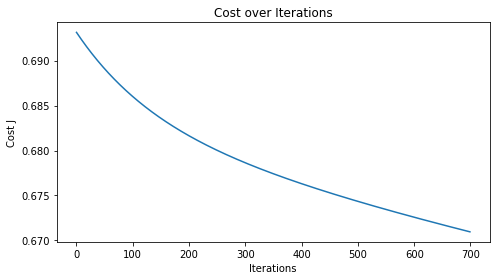

In [64]:
# Graph loss function change
plt.figure(figsize=(7, 4))

plt.plot(np.array(Js).flatten())
plt.xlabel("Iterations")
plt.ylabel("Cost J")
plt.title("Cost over Iterations")

plt.tight_layout()
plt.show()

In [65]:
# Test your function
w1_unittest.test_gradientDescent(gradientDescent)

 All tests passed


<a name='2'></a>
## 2 - Extracting the Features

* Given a list of tweets, extract the features and store them in a matrix. You will extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Then train your logistic regression classifier on these features.
* Test the classifier on a validation set. 

<a name='ex-3'></a>
### Exercise 3 - extract_features
Implement the extract_features function. 
* This function takes in a single tweet.
* Process the tweet using the imported `process_tweet` function and save the list of tweet words.
* Loop through each word in the list of processed words
    * For each word, check the 'freqs' dictionary for the count when that word has a positive '1' label. (Check for the key (word, 1.0)
    * Do the same for the count for when the word is associated with the negative label '0'. (Check for the key (word, 0.0).)

**Note:** In the implementation instructions provided above, the prediction of being positive or negative depends on feature vector which counts-in duplicate words - this is different from what you have seen in the lecture videos

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Make sure you handle cases when the (word, label) key is not found in the dictionary. </li>
    <li> Search the web for hints about using the 'get' function of a Python dictionary.  Here is an <a href="https://www.programiz.com/python-programming/methods/dictionary/get" > example </a> </li>
</ul>
</p>


In [66]:
tweet = "I am sad, I am not learning NLP"
process_tweet(tweet)

['sad', 'learn', 'nlp']

In [67]:
# UNQ_C3 GRADED FUNCTION: extract_features
def extract_features(tweet, freqs, process_tweet=process_tweet):
    '''
    Input: 
        tweet: a string containing one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements for [bias, positive, negative] counts
    x = np.zeros(3) 
    
    # bias term is set to 1
    x[0] = 1 
    
    ### START CODE HERE ###
    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[1] += freqs.get((word,1), 0)
        
        # increment the word count for the negative label 0
        x[2] += freqs.get((word,0), 0)
        
    ### END CODE HERE ###
    
    x = x[None, :]  # adding batch dimension for further processing
    assert(x.shape == (1, 3))
    return x

In [68]:
# Check your function
# test 1
# test on training data
tmp1 = extract_features(train_x[0], freqs)
print(tmp1)

[[1.000e+00 3.133e+03 6.100e+01]]


#### Expected output
```
[[1.000e+00 3.133e+03 6.100e+01]]
```

In [69]:
# test 2:
# check for when the words are not in the freqs dictionary
tmp2 = extract_features('blorb bleeeeb bloooob', freqs)
print(tmp2)

[[1. 0. 0.]]


#### Expected output
```
[[1. 0. 0.]]
```

In [70]:
# Test your function
w1_unittest.test_extract_features(extract_features, freqs)

 All tests passed


<a name='3'></a>
## 3 - Training Your Model

To train the model:
* Stack the features for all training examples into a matrix X. 
* Call `gradientDescent`, which you've implemented above.

This section is given to you.  Please read it for understanding and run the cell.

In [71]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.22522315.
The resulting vector of weights is [6e-08, 0.00053818, -0.0005583]


**Expected Output**: 

```
The cost after training is 0.22522315.
The resulting vector of weights is [6e-08, 0.00053818, -0.0005583]
```

<a name='4'></a>
## 4 -  Test your Logistic Regression

It is time for you to test your logistic regression function on some new input that your model has not seen before. 
<a name='ex-4'></a>
### Exercise 4 - predict_tweet
Implement `predict_tweet`.
Predict whether a tweet is positive or negative.

* Given a tweet, process it, then extract the features.
* Apply the model's learned weights on the features to get the logits.
* Apply the sigmoid to the logits to get the prediction (a value between 0 and 1).

$$y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$$

In [76]:
# UNQ_C4 GRADED FUNCTION: predict_tweet
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    ### START CODE HERE ###
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))
    
    ### END CODE HERE ###
    
    return y_pred

In [77]:
# Run this cell to test your function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta)))    
    

I am happy -> 0.519275
I am bad -> 0.494347
this movie should have been great. -> 0.515979
great -> 0.516065
great great -> 0.532096
great great great -> 0.548062
great great great great -> 0.563929


**Expected Output**: 
```
I am happy -> 0.519275
I am bad -> 0.494347
this movie should have been great. -> 0.515979
great -> 0.516065
great great -> 0.532096
great great great -> 0.548062
great great great great -> 0.563929
```

In [78]:
# Feel free to check the sentiment of your own tweet below
my_tweet = 'I am learning :)'
predict_tweet(my_tweet, freqs, theta)

array([[0.83110307]])

In [79]:
# Test your function
w1_unittest.test_predict_tweet(predict_tweet, freqs, theta)

 All tests passed


<a name='4-1'></a>
### 4.1 -  Check the Performance using the Test Set
After training your model using the training set above, check how your model might perform on real, unseen data, by testing it against the test set.

<a name='ex-5'></a>
### Exercise 5 - test_logistic_regression
Implement `test_logistic_regression`. 
* Given the test data and the weights of your trained model, calculate the accuracy of your logistic regression model. 
* Use your 'predict_tweet' function to make predictions on each tweet in the test set.
* If the prediction is > 0.5, set the model's classification 'y_hat' to 1, otherwise set the model's classification 'y_hat' to 0.
* A prediction is accurate when the y_hat equals the test_y.  Sum up all the instances when they are equal and divide by m.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Use np.asarray() to convert a list to a numpy array</li>
    <li>Use numpy.squeeze() to make an (m,1) dimensional array into an (m,) array </li>
</ul>
</p>

In [96]:
# UNQ_C5 GRADED FUNCTION: test_logistic_regression
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    ### START CODE HERE ###
    
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = sum(test_y.flatten() == np.array(y_hat)) / len(test_y)

    ### END CODE HERE ###
    
    return accuracy

In [97]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9950


#### Expected Output: 
```0.9950```  
Pretty good!

In [98]:
# Test your function
w1_unittest.unittest_test_logistic_regression(test_logistic_regression, freqs, theta)

 All tests passed


<a name='5'></a>
## 5 -  Error Analysis

In this part you will see some tweets that your model misclassified. Why do you think the misclassifications happened? Specifically what kind of tweets does your model misclassify?

In [99]:
# Some error analysis done for you
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
THE PROCESSED TWEET IS: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
1	0.48901497	b'sure would good thing 4 bottom dare 2 say 2 miss b im gonna stubborn mouth soap nothavingit :p'
THE TWEET IS: I'm playing Brain Dots : ) #BrainDots
http://t.co/UGQzOx0huu
THE PROCESSED TWEET IS: ["i'm", 'play', 'brain', 'dot', 'braindot']
1	0.48418949	b"i'm play brain dot braindot"
THE TWEET IS: I'm playing Brain Dots : ) #BrainDots http://t.co/aOKldo3GMj http://t.co/xWCM9qyRG5
THE PROCESSED TWEET IS: ["i'm", 'play', 'brain', 'dot', 'braindot']
1	0.48418949	b"i'm play brain dot braindot"
THE TWEET IS: I'm playing Brain Dots : ) #BrainDots http://t.co/R2JBO8iNww http://t.co/ow5BBwdEMY
THE PROCESSED TWEET IS: ["i'm", 'play', 

Later in this specialization, we will see how we can use deeplearning to improve the prediction performance.

<a name='6'></a>
## 6 - Predict with your own Tweet

In [100]:
# Feel free to change the tweet below
my_tweet = 'This is a ridiculously bright movie. The plot was terrible and I was sad until the ending!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['ridicul', 'bright', 'movi', 'plot', 'terribl', 'sad', 'end']
[[0.48125423]]
Negative sentiment
